In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
data = pd.read_excel('/content/drive/MyDrive/country_lyrics.xlsx')

In [4]:
data.head()

,Song,Artist,Featuring,Entered Top 30 In:,Lyrics,Writers,Producer,Rough Order,Unnamed: 8,RULES!!!! Top 30 Country Airplay From March 2014-March 2017
0,Wake Up Lovin You,Craig Morgan,NaN,2013,My friends call me up 'cause they know I'm dow...,"Josh Osborne, Matthew Ramsey, Trevor Rosen","Craig Morgan, Phil O'Donnell",1,NaN,NaN
1,Young Love,Kip Moore,NaN,2013,"Your daddy thought I was wrong for you, Thinki...","Kip Moore, Dan Couch, Westin Davis",Brett James,2,NaN,NaN
2,Beat of the Music,Brett Eldredge,NaN,2013,Well I just met you a couple hours ago My last...,"Brett Eldredge, Ross Copperman, Heather Morgan","Brett Eldredge, Ross Copperman",3,NaN,NaN
3,The Heart of Dixie,Danielle Bradbery,NaN,2013,She had a dead-end job at the National Bank An...,"Brett James, Caitlyn Smith, Troy Verges",Brett James,4,NaN,NaN
4,Everything I Shouldn't Be Thinking About,Thompson Square,NaN,2013,My motorcycle needs an oil change Fence needs ...,"Keifer Thompson, Shawna Thompson, David Lee Mu...","RIch Redmond, Kurt Allison, Tully Kennedy, Dav...",5,NaN,NaN


In [5]:
data.columns

Index(['Song', 'Artist', 'Featuring', 'Entered Top 30 In:', 'Lyrics',
       'Writers', 'Producer', 'Rough Order', 'Unnamed: 8',
       'RULES!!!! Top 30 Country Airplay From March 2014-March 2017'],
      dtype='object')

In [6]:
dataset = data.iloc[:,:8]

## Analyze top artists

In [7]:
dataset[['Artist','Song']].groupby(['Artist']).count().sort_values(by='Song',ascending=False).reset_index().head(10)

,Artist,Song
0,Luke Bryan,16
1,Blake Shelton,15
2,Thomas Rhett,14
3,Jason Aldean,14
4,Florida Georgia Line,13
5,Keith Urban,12
6,Tim McGraw,11
7,Kenny Chesney,11
8,Eric Church,11
9,Cole Swindell,10


In [8]:
dataset[['Producer','Song']].groupby(['Producer']).count().sort_values(by='Song',ascending=False).reset_index().head(10)

,Producer,Song
0,Dann Huff,31
1,Jay Joyce,27
2,Joey Moi,26
3,Scott Hendricks,23
4,Michael Knox,14
5,Ross Copperman,11
6,"Jeff Stevens, Jody Stevens",11
7,Michael Carter,10
8,Shane McAnally,9
9,busbee,8


In [9]:
print(len(dataset.Producer.unique()))
print(len(dataset.Artist.unique()))

180
121


In [10]:
dataset['temp'] = dataset.Producer.str.split(',')
dataset_prod = (dataset.set_index(['Song', 'Artist', 'Featuring', 'Entered Top 30 In:', 'Lyrics','Writers', 'Producer', 'Rough Order'])['temp'].apply(pd.Series).stack().reset_index().drop('level_8', axis=1).rename(columns={0:'all_producers'}))

In [11]:
dataset_prod[['all_producers','Song']].groupby(['all_producers']).count().sort_values(by='Song',ascending=False).reset_index().head(10)

,all_producers,Song
0,Dann Huff,51
1,Joey Moi,28
2,Jay Joyce,27
3,Scott Hendricks,24
4,Ross Copperman,22
5,Jeff Stevens,15
6,Michael Knox,14
7,Zach Crowell,13
8,Byron Gallimore,12
9,busbee,12


In [12]:
data_lyrics = data.iloc[:,4:5]
data_lyrics.head()

,Lyrics
0,My friends call me up 'cause they know I'm dow...
1,"Your daddy thought I was wrong for you, Thinki..."
2,Well I just met you a couple hours ago My last...
3,She had a dead-end job at the National Bank An...
4,My motorcycle needs an oil change Fence needs ...


In [13]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning function
def clean_lyrics(lyrics, bigrams=False, stemm=False):
    lyrics = lyrics.lower() # lower case
    lyrics = re.sub('['+my_punctuation + ']+', ' ', lyrics) # strip punctuation
    lyrics = re.sub('\s+', ' ', lyrics) #remove double spacing
    lyrics = re.sub('([0-9]+)', '', lyrics) # remove numbers
    lyrics_token_list = [word for word in lyrics.split(' ') if word not in my_stopwords] # remove stopwords

    if stemm:
      lyrics_token_list = [word_rooter(word) if '#' not in word else word for word in lyrics_token_list] # apply word rooter
    
    if bigrams:
        lyrics_token_list = lyrics_token_list+[lyrics_token_list[i]+'_'+lyrics_token_list[i+1]
                                            for i in range(len(lyrics_token_list)-1)]
    lyrics = ' '.join(lyrics_token_list)
    return lyrics

In [14]:
data_lyrics['Lyrics'] = data_lyrics.Lyrics.apply(clean_lyrics)

In [15]:
data_lyrics.head()

,Lyrics
0,friends call cause know take paint town help g...
1,daddy thought wrong thinking back mom two wron...
2,well met couple hours ago last night town hey ...
3,dead end job national bank deadbeat husband al...
4,motorcycle needs oil change fence needs mendin...


In [16]:
def _vectorize(df, max_df, min_df, max_feat=None):
  vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_feat)
  # apply transformation
  tf = vectorizer.fit_transform(df['Lyrics']).toarray()
  # tf_feature_names tells us what word each column in the matric represents
  tf_feature_names = vectorizer.get_feature_names()
  return [tf,tf_feature_names]

def tf_idf(df, max_df, min_df, max_feat=None):
  tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_feat, stop_words='english')
  tfidf = tfidf_vectorizer.fit_transform(df['Lyrics'])
  tfidf_feature_names = tfidf_vectorizer.get_feature_names() 
  return [tfidf,tfidf_feature_names]

In [17]:
# ## LDA the vectorizer object will be used to transform text to vector form
# vectorizer = CountVectorizer(max_df=0.9, min_df=2, max_features=1000)
# # apply transformation
# tf = vectorizer.fit_transform(data_lyrics['Lyrics']).toarray()
# # tf_feature_names tells us what word each column in the matric represents
# tf_feature_names = vectorizer.get_feature_names()

# ## NMF
# # NMF is able to use tf-idf
# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# tfidf = tfidf_vectorizer.fit_transform(data_lyrics['Lyrics'])
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()

## Added NMF alsong with LDA
NMF gives better topics than the topics defined by LDA

In [18]:
number_of_topics = 5
tf,tf_feature_names = _vectorize(data_lyrics, max_df=0.9, min_df=2)
model_lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=10, batch_size=32)
tfidf,tfidf_feature_names = tf_idf(data_lyrics, max_df=0.95, min_df=2)
model_nmf = NMF(n_components=number_of_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')

In [19]:
tf.shape

(484, 2568)

In [20]:
print(model_lda.fit(tf))
print(model_nmf.fit(tfidf))

LatentDirichletAllocation(batch_size=32, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=10, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)
NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5, max_iter=200,
    n_components=5, random_state=1, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)


In [21]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [22]:
no_top_words = 10
display_topics(model_lda, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,back,306.6,like,591.4,oh,372.6,got,123.8,love,336.6
1,yeah,297.6,yeah,300.6,got,322.0,one,113.9,gonna,313.7
2,wanna,280.2,got,241.3,like,227.8,need,92.3,know,246.4
3,girl,266.6,know,207.5,little,210.4,em,89.4,get,186.4
4,like,266.2,little,205.7,love,208.4,good,87.5,girl,180.5
5,little,255.2,get,181.9,baby,200.5,round,70.2,never,176.0
6,baby,229.8,oh,178.6,know,190.3,night,64.9,like,170.7
7,time,201.2,baby,162.1,yeah,182.6,day,60.9,go,166.8
8,know,199.3,right,151.9,somebody,177.0,yeah,59.7,yeah,156.6
9,every,198.8,way,147.2,girl,162.3,gone,57.8,one,138.3


In [23]:
no_top_words = 10
display_topics(model_nmf, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,last,0.6,montana,1.8,lighters,1.7,touch,1.7,shout,1.5
1,football,0.5,vacation,0.2,motown,0.6,lives,0.6,fruity,0.3
2,front,0.5,video,0.1,groove,0.2,fresh,0.4,jail,0.2
3,attention,0.5,closing,0.1,dresses,0.2,living,0.2,john,0.1
4,wasted,0.5,month,0.1,fresh,0.2,boot,0.1,cuz,0.1
5,john,0.5,lost,0.1,beautiful,0.1,choice,0.1,strings,0.1
6,lead,0.4,style,0.1,lace,0.1,droppin,0.1,footsteps,0.1
7,swagger,0.3,grandpa,0.1,break,0.1,kid,0.1,loose,0.1
8,pulled,0.3,twisted,0.1,candles,0.1,daze,0.1,laughing,0.1
9,know,0.3,poor,0.1,guys,0.1,tailgate,0.1,found,0.0


## Clustering the lyrics 
Do a K-means and hierarchical clustering on the lyrics to find similar songs.
Do I need clustering? check

## Adding new lyrics 
Adding data for other genres to create a classification model by identifying country songs from the lyrics. Getting data from data.world https://data.world/typhon/billboard-hot-100-songs-2000-2018-w-spotify-data-lyrics
The data has lyrics and genres for mostly pop and rock songs. This should make the total data imbalanced and difficult for classification.


In [24]:
## check the encoding of the file
import chardet
with open('/content/drive/MyDrive/lyrics-data.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [25]:
new_lyrics = pd.read_csv('/content/drive/MyDrive/lyrics-data.csv')

In [26]:
new_lyrics = new_lyrics.iloc[:,3:4]
new_lyrics['Lyric'] = new_lyrics.Lyric.apply(clean_lyrics)

In [27]:
# create a new column with 
data_lyrics['label'] = 1
new_lyrics['label'] = 0

In [28]:
data_lyrics.columns
data_lyrics = data_lyrics.append(new_lyrics.rename(columns={'Lyric':'Lyrics'}), ignore_index=True)

Less than 1 percent songs are from the country genre. This would create problems for classification. 

In [29]:
(data_lyrics.label.value_counts()/len(data_lyrics))*100

0    99.579872
1     0.420128
Name: label, dtype: float64

## Classifying the lyrics
Trying to classify songs into country and non country based on lyrics alone. 

### Exploring data

In [30]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def song_length_distribution(data_lyrics):
  lyrics_length = list(data_lyrics.Lyrics.str.len())
  plt.hist(lyrics_length, 50)
  plt.xlabel('Length of a song')
  plt.ylabel('Number of songs')
  plt.title('Song length distribution')
  plt.show()

Country songs seem to have fewer words than songs from other genres

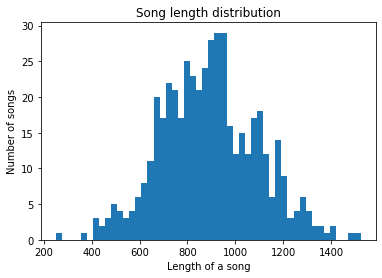

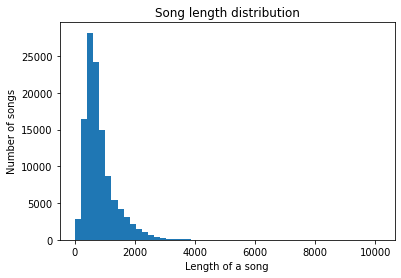

In [31]:
song_length_distribution(data_lyrics[data_lyrics.label == 1])
song_length_distribution(data_lyrics[data_lyrics.label == 0])

### Word cloud for Country and Non-country songs
No real topic from non-country songs which probably makes sense because there are songs from all different kind of genres but life seems to be the most common word. Country songs seem to have words such as 'girl','baby','like','love','heart' which suggests maybe those are all related to love/heartbreak 

In [32]:
def gen_wrd_cld(all_lyrics):
  all_lyrics = ' '.join(all_lyrics)
  wrd_cld = WordCloud(stopwords=['know','got']).generate(str(all_lyrics))
  plt.imshow(wrd_cld)
  plt.axis("off")
  plt.show()

In [33]:
all_lyrics_cty = data_lyrics[data_lyrics.label == 1].Lyrics.values
all_lyrics_n_cty = data_lyrics[data_lyrics.label == 0].Lyrics.values

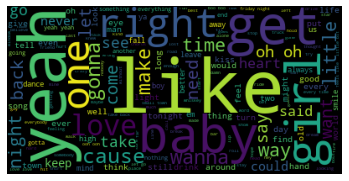

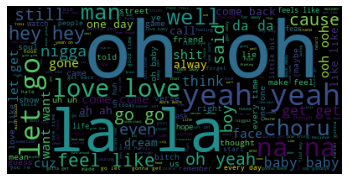

In [34]:
gen_wrd_cld(all_lyrics_cty)
gen_wrd_cld(all_lyrics_n_cty)

### Undersampling the data
Creating a new dataset which is less imbalanced for classification models. 99.5 to 0.5 ratio data would not classify anything from the minority class and end up classifying all the songs as non country. 

In [40]:
## Using Imblearn
X = data_lyrics.Lyrics
## reshaping to (rows,1) instead of (rows,)
X = np.array(X).reshape(-1,1)
y = data_lyrics.label

undersample = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = undersample.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [69]:
print('Old ratio:',Counter(y))
print('New ratio',Counter(y_under))

Old ratio: Counter({0: 114719, 1: 484})
New ratio Counter({0: 968, 1: 484})


Undersampling with pandas instead of imblearn

In [35]:
# Separate majority and minority classes
df_majority = data_lyrics[data_lyrics.label==0]
df_minority = data_lyrics[data_lyrics.label==1]
## twice the number of country songs 
df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(data_lyrics[data_lyrics.label==1])*2, random_state=54)

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [36]:
df_downsampled.reset_index(inplace=True)
df_downsampled.label.value_counts()

0    968
1    484
Name: label, dtype: int64

### Building features and models
Using countvectorizer and tfidf on the entire data to create features

In [37]:
X,feat_names = tf_idf(df_downsampled,max_df=0.9,min_df=2)
y = df_downsampled['label']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=65)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 725, 1: 364})
Testing target statistics: Counter({0: 243, 1: 120})


### Models

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [40]:
def eval_metrics(classifier, X_test, y_predict):
  ## probabilities of each class, [:,1] for probabilities of 1
  y_prob = classifier.predict_proba(X_test)[:,1]
  fpr,tpr,threshold = roc_curve(y_test, y_prob)
  print(classification_report(y_true=y_test, y_pred=y_predict))
  print('----------------------------------------------------------')
  print(confusion_matrix(y_true=y_test, y_pred=y_predict))
  print('----------------------------------------------------------')
  print('AUC:',auc(fpr,tpr))

#### Logistic
Recall rate is not that high which means the model did not predict almost 50% of the country songs. However, precision was decent

In [41]:
classifier = LogisticRegression(solver='liblinear', penalty='l2')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8099173553719008


In [43]:
y_pred_logistic = classifier.predict(X_test)
eval_metrics(classifier=classifier, X_test=X_test, y_predict=y_pred_logistic)

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       243
           1       0.86      0.51      0.64       120

    accuracy                           0.81       363
   macro avg       0.83      0.73      0.75       363
weighted avg       0.82      0.81      0.79       363

----------------------------------------------------------
[[233  10]
 [ 59  61]]
----------------------------------------------------------
AUC: 0.926440329218107


Naive Bayes

In [45]:
classifier_nb = MultinomialNB()
classifier_nb.fit(X_train, y_train) 
score = classifier_nb.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.7548209366391184


In [46]:
y_pred_nb = classifier_nb.predict(X_test)
eval_metrics(classifier=classifier_nb, X_test=X_test, y_predict=y_pred_nb)

              precision    recall  f1-score   support

           0       0.74      0.99      0.84       243
           1       0.92      0.28      0.43       120

    accuracy                           0.75       363
   macro avg       0.83      0.64      0.64       363
weighted avg       0.80      0.75      0.71       363

----------------------------------------------------------
[[240   3]
 [ 86  34]]
----------------------------------------------------------
AUC: 0.9014060356652949
